# Polyp Detection / Segmentation

In [22]:
#imports n stuff
import numpy as np
import pandas as pd
import keras as k
#!pip install tensorflow==2.0.0-alpha0
import tensorflow as tf
import os
from skimage import io
from matplotlib import pyplot as plt
from PIL import Image, ImageFile
import imageio
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
import gc
import sklearn
import cv2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')
tf.__version__

'2.0.0-alpha0'

## Importing files and converting them to bit array / preprocessing

In [23]:
#get_ipython().system_raw("unrar x ETIS-LaribPolypDB.rar")

In [24]:
def to_pixle_array(filepath):
    im = imageio.imread(filepath)
    imarray = np.array(im)
    return imarray

def to_3_channel(im_array):
    return np.stack((im_array,)*3, axis=-1)

In [25]:
g_truth = []
directory_in_str = 'Ground Truth/'
directory = os.fsdecode(directory_in_str)
for file in os.listdir(directory):
    filename = os.path.join(directory,os.fsdecode(file))
    g_truth.append(to_3_channel(to_pixle_array(filename)))
    continue

g_truth = (np.array(g_truth)/255).astype('float32')
g_truth.shape

(612, 288, 384, 3)

In [26]:
original = []
directory_in_str2 = 'Original/'
directory2 = os.fsdecode(directory_in_str2)

for file2 in os.listdir(directory2):
    filename2 = os.path.join(directory2,os.fsdecode(file2))
    original.append(to_pixle_array(filename2))
    continue
  
original = (np.array(original)/255).astype('float32')
original.shape

(612, 288, 384, 3)

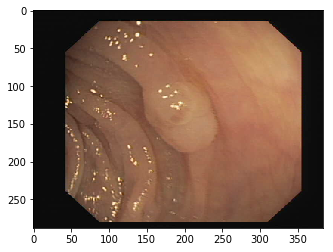

In [27]:
plt.imshow(original[1]);

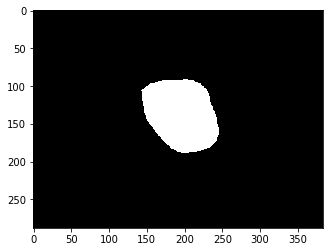

In [28]:
plt.imshow(g_truth[1]);

In [29]:
def overlay(num):
    plt.imshow(g_truth[num], cmap = 'gray')
    plt.imshow(original[num], alpha=.6)
  
interact(overlay, num=30);

interactive(children=(IntSlider(value=30, description='num', max=90, min=-30), Output()), _dom_classes=('widge…

## Segmentation vs Classification vs Recognition


## Transfer learning base

In [99]:
'''from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(original, g_truth, test_size=.25)
INPUT_SHAPE = x_train[0].shape'''

### Building the CNN base from the VGG16 model

In [104]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation


In [117]:
basemodel = VGG16(weights='imagenet', include_top=False, input_shape = (150, 150, 3))
basemodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [118]:
basemodel.trainable = False
    
model = Sequential([
    basemodel,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(1),
])

model.compile(loss="binary_crossentropy", optimizer = tf.keras.optimizers.SGD(lr=.0001, momentum=.9), metrics=['accuracy'])



In [119]:
BATCH_SIZE = 32
datagen = ImageDataGenerator(rescale=float(1/255), rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

train_generator = datagen.flow_from_directory(directory = 'data_polyps/train', class_mode = 'binary', 
                                                    batch_size=BATCH_SIZE, target_size = (150, 150))

val_generator = datagen.flow_from_directory(directory = 'data_polyps/validation', class_mode = 'binary', 
                                                    batch_size=BATCH_SIZE, target_size = (150, 150))


Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


In [ ]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = val_generator.n//val_generator.batch_size

model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = val_generator,
                   validation_steps = step_size_valid,
                   epochs=32)

Epoch 1/32
28/28 [==============================] - 194s 7s/step - loss: 5.4922 - accuracy: 0.5330 - val_loss: 7.4673 - val_accuracy: 0.5035
Epoch 2/32


In [ ]:
score = model.evaluate_generator(val_generator, step_size_valid, workers=7)
print('Validation/Test loss    :', score[0])
print('Validation/Test accuracy:', score[1])